
# 03 — Modeling (Baseline Logistic Regression)

**Tujuan:**  
- Memuat dataset **interim** hasil cleaning (notebook 02) atau fallback ke sample.  
- Menentukan **fitur numerik vs kategorik**.  
- Membangun **pipeline**: imputer (median/most-freq) + scaler + one-hot + **Logistic Regression**.  
- Evaluasi **CV**: ROC-AUC, PR-AUC, KS + tabel skenario **approve vs bad-rate**.  
- **GridSearch** untuk `C` & `class_weight`.  
- Simpan **model** dan **metrik** untuk presentasi.


In [1]:

from pathlib import Path
import os

MY_DATA_DIR = Path("C:/Users/felix/hci_final_project/data")
DATA_DIR = MY_DATA_DIR if MY_DATA_DIR.exists() else Path("data")

INTERIM = DATA_DIR / "interim"
SAMPLE  = DATA_DIR / "sample" / "application_train_sample.csv"
RAW     = DATA_DIR / "raw" / "application_train.csv"

TARGET = "TARGET"
ID_COL = "SK_ID_CURR"

print("DATA_DIR:", DATA_DIR.resolve())
print("INTERIM :", INTERIM)


DATA_DIR: C:\Users\felix\hci_final_project\data
INTERIM : C:\Users\felix\hci_final_project\data\interim


In [2]:

import pandas as pd

def _add_base_features(df: pd.DataFrame) -> pd.DataFrame:
    import numpy as np
    df = df.copy()
    if "DAYS_EMPLOYED" in df.columns:
        anom = df["DAYS_EMPLOYED"] == 365243
        df["DAYS_EMPLOYED_ANOM"] = anom.astype("int8")
        df.loc[anom, "DAYS_EMPLOYED"] = np.nan
    if "DAYS_BIRTH" in df.columns:
        df["AGE_YEARS"] = (-df["DAYS_BIRTH"] / 365.25)
    if "DAYS_EMPLOYED" in df.columns:
        df["EMP_YEARS"] = (-df["DAYS_EMPLOYED"] / 365.25)
    if "CODE_GENDER" in df.columns:
        df["CODE_GENDER"] = df["CODE_GENDER"].replace({"XNA": pd.NA})
    if {"AMT_CREDIT","AMT_INCOME_TOTAL"}.issubset(df.columns):
        df["R_CREDIT_INCOME"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"].replace({0: pd.NA})
    if {"AMT_ANNUITY","AMT_INCOME_TOTAL"}.issubset(df.columns):
        df["R_ANNUITY_INCOME"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"].replace({0: pd.NA})
    return df

def load_interim_or_sample() -> pd.DataFrame:
    candidates = [
        INTERIM / "application_train_sample_clean.parquet",
        INTERIM / "application_train_clean.parquet",
        INTERIM / "application_train_sample_clean.csv.gz",
        INTERIM / "application_train_clean.csv.gz",
    ]
    for p in candidates:
        if p.exists():
            if p.suffix == ".parquet":
                try:
                    return pd.read_parquet(p)
                except Exception as e:
                    print("Gagal baca parquet, coba csv.gz fallback:", e)
            else:
                return pd.read_csv(p, low_memory=False)
    if SAMPLE.exists():
        df = pd.read_csv(SAMPLE, low_memory=False)
        return _add_base_features(df)
    if RAW.exists():
        df = pd.read_csv(RAW, low_memory=False)
        return _add_base_features(df)
    raise FileNotFoundError("Tidak menemukan file interim/sample/raw yang diharapkan.")

df = load_interim_or_sample()
print(df.shape)
df.head(3)


(12387, 127)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,AGE_YEARS,EMP_YEARS,R_CREDIT_INCOME,R_ANNUITY_INCOME
0,333721,0,Cash loans,M,Y,Y,1,292500.0,1102500.0,32364.0,...,0.0,0.0,0.0,0.0,1.0,0,32.205338,1.883641,3.769231,0.110646
1,110157,0,Revolving loans,F,N,Y,0,270000.0,720000.0,36000.0,...,0.0,0.0,1.0,0.0,2.0,1,63.515400,NaN,2.666667,0.133333
2,276815,0,Revolving loans,F,Y,Y,1,135000.0,360000.0,18000.0,...,0.0,0.0,0.0,0.0,0.0,0,52.470909,9.396304,2.666667,0.133333


In [3]:

import pandas as pd

assert TARGET in df.columns, f"Kolom target '{TARGET}' tidak ditemukan."

drop_cols = [c for c in [TARGET, ID_COL] if c in df.columns]
X = df.drop(columns=drop_cols)
y = df[TARGET].astype(int).to_numpy()

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

print("Num cols:", len(num_cols), "| Cat cols:", len(cat_cols))
print("Sample numeric:", num_cols[:6])
print("Sample categ. :", cat_cols[:6])


Num cols: 109 | Cat cols: 16
Sample numeric: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE']
Sample categ. : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE']


In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

logreg = LogisticRegression(
    solver="saga",
    penalty="l2",
    max_iter=1000,
    class_weight=None
)

pipe = Pipeline([("prep", preprocess), ("clf", logreg)])
pipe


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:

import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, brier_score_loss

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]

roc_auc = roc_auc_score(y, y_proba)
pr_auc  = average_precision_score(y, y_proba)

fpr, tpr, thr = roc_curve(y, y_proba)
ks = np.max(tpr - fpr)
brier = brier_score_loss(y, y_proba)

print({"roc_auc": round(roc_auc,4), "pr_auc": round(pr_auc,4), "ks": round(float(ks),4), "brier": round(brier,4)})


c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'roc_auc': 0.727, 'pr_auc': 0.1938, 'ks': 0.3454, 'brier': 0.0708}


c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [6]:

import numpy as np
import pandas as pd

def scenario_table(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.5, 10)
    rows = []
    for t in thresholds:
        approve = y_prob < t           # 0=approve, 1=reject
        approvals = approve.sum()
        bad_rate = (y_true[approve] == 1).mean() if approvals > 0 else np.nan
        rows.append({"threshold": round(float(t),3),
                     "approval_rate": approvals/len(y_true),
                     "bad_rate_among_approved": bad_rate})
    return pd.DataFrame(rows)

scen = scenario_table(y, y_proba)
scen.head(10)


,threshold,approval_rate,bad_rate_among_approved
0,0.05,0.483006,0.032425
1,0.10,0.740615,0.047853
2,0.15,0.858965,0.058741
3,0.20,0.916768,0.065956
4,0.25,0.949059,0.070262
5,0.30,0.968112,0.073382
6,0.35,0.980302,0.075929
7,0.40,0.986357,0.077018
8,0.45,0.990635,0.078559
9,0.50,0.994268,0.079571


In [7]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "clf__class_weight": [None, "balanced"],
    "clf__penalty": ["l2"],
}

grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=1)
grid.fit(X, y)

print("Best ROC-AUC:", round(grid.best_score_,4))
print("Best params :", grid.best_params_)
best_pipe = grid.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best ROC-AUC: 0.7323
Best params : {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2'}


c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

y_proba_best = cross_val_predict(best_pipe, X, y, cv=cv, method="predict_proba")[:,1]

roc_auc_b = roc_auc_score(y, y_proba_best)
pr_auc_b  = average_precision_score(y, y_proba_best)
fpr_b, tpr_b, _ = roc_curve(y, y_proba_best)
import numpy as np
ks_b = np.max(tpr_b - fpr_b)
print({"roc_auc": round(roc_auc_b,4), "pr_auc": round(pr_auc_b,4), "ks": round(float(ks_b),4)})


c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'roc_auc': 0.732, 'pr_auc': 0.1982, 'ks': 0.3511}


c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:

def pick_threshold_under_bad_rate(y_true, y_prob, bad_rate_limit=0.05):
    tbl = scenario_table(y_true, y_prob, thresholds=np.linspace(0.01,0.5,50)).dropna()
    ok = tbl[tbl["bad_rate_among_approved"] <= bad_rate_limit]
    if len(ok)==0:
        return None, tbl
    best = ok.sort_values(["approval_rate","threshold"], ascending=[False, True]).iloc[0]
    return float(best["threshold"]), tbl

thr_star, scen_best = pick_threshold_under_bad_rate(y, y_proba_best, bad_rate_limit=0.05)
thr_star, scen_best.head()


(0.1,
    threshold  approval_rate  bad_rate_among_approved
 0       0.01       0.044644                 0.018083
 1       0.02       0.151933                 0.019129
 2       0.03       0.262049                 0.023105
 3       0.04       0.371761                 0.028013
 4       0.05       0.460483                 0.031381)

In [10]:

from joblib import dump
import json

MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True, parents=True)
REPORTS_DIR = Path("reports"); REPORTS_DIR.mkdir(exist_ok=True, parents=True)

best_pipe.fit(X, y)

model_path = MODELS_DIR / "logreg_pipeline.joblib"
dump(best_pipe, model_path)

metrics = {
    "cv_roc_auc": float(roc_auc_b),
    "cv_pr_auc": float(pr_auc_b),
    "cv_ks": float(ks_b),
    "chosen_threshold_bad_rate<=5pct": thr_star
}
with open(REPORTS_DIR / "03_logreg_metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

model_path, metrics


c:\Users\felix\hci_final_project\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(WindowsPath('models/logreg_pipeline.joblib'),
 {'cv_roc_auc': 0.7319643453060507,
  'cv_pr_auc': 0.19817990147421563,
  'cv_ks': 0.3510742952489681,
  'chosen_threshold_bad_rate<=5pct': 0.1})

'Saved figures to reports/figures'

<Figure size 640x480 with 0 Axes>

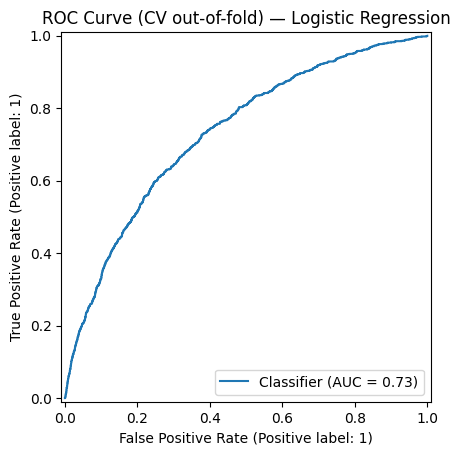

<Figure size 640x480 with 0 Axes>

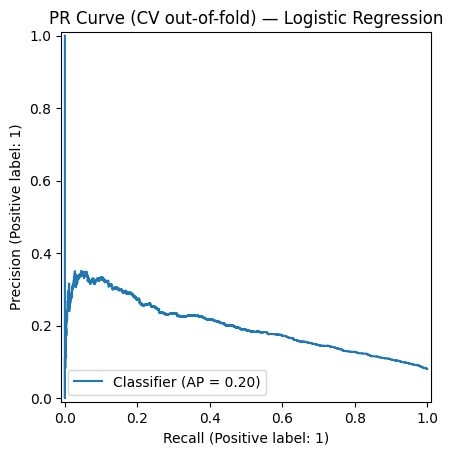

In [11]:

import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

FIG_DIR = Path("reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

fig1 = plt.figure()
RocCurveDisplay.from_predictions(y, y_proba_best)
plt.title("ROC Curve (CV out-of-fold) — Logistic Regression")
plt.savefig(FIG_DIR / "logreg_roc.png", bbox_inches="tight")

fig2 = plt.figure()
PrecisionRecallDisplay.from_predictions(y, y_proba_best)
plt.title("PR Curve (CV out-of-fold) — Logistic Regression")
plt.savefig(FIG_DIR / "logreg_pr.png", bbox_inches="tight")

"Saved figures to reports/figures"
